In [1]:
library(ArchR)
library(parallel)
library(biosignals)
set.seed(1)
addArchRThreads(threads = 16) 

Loading required package: ggplot2

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats

In [2]:
addArchRGenome("hg38")

Setting default genome to Hg38.



# Input data

In [3]:
root = '/Genomics/pritykinlab/zzhao/sc-atac-submmit-calling'
scatac_input = 'data/pbmc10k/pbmc_granulocyte_sorted_10k_atac_fragments.tsv.gz'
scatac_input = paste(root, scatac_input, sep="/")
out_dir = "results/pbmc_coassay_processed/"
out_dir = paste(root, out_dir, sep="/")
archr_out = "results/pbmc_archR_output/"
archr_out = paste(root, archr_out, sep="/")

In [4]:
archr_out

[1] "/Genomics/pritykinlab/zzhao/sc-atac-submmit-calling/results/pbmc_archR_output/"

# create arrow files and preprocess data

In [5]:
# Create Arrow files, filter

ArrowFiles <- createArrowFiles(
  inputFiles = c(scatac_input),
  sampleNames = c("coassay_analysis"),
  minTSS = 10, #Dont set this too high because you can always increase later
  minFrags = 2500, # both TSS and Frags have different parameter names from the tutorial, using minFrags and minTSS instead.
  addTileMat = TRUE, # Set to False and add non-binarized matrix for non-binarized LSI using code below
  addGeneScoreMat = TRUE,
  force = TRUE
)

##### Use ArchR 1.0.2 to run LSI with non-binarized matrices
# proj <- ArchRProject(
#   ArrowFiles = ArrowFiles,
#   outputDirectory = archr_out,
#   copyArrows = TRUE                                                    
# )
# proj <- addTileMatrix(proj, binarize=FALSE, force=TRUE)
# proj<- addIterativeLSI(ArchRProj = proj, 
#     useMatrix = "TileMatrix",
#     name = "IterativeLSICeiling",
#     iterations = 4,
#     clusterParams = list( #See Seurat::FindClusters
#         resolution = c(1.5),
#         sampleCells = 10000,
#         n.start = 10,
#         maxClusters = 25
#      ),
#     varFeatures = 25000,
#     dimsToUse = 1:30,
#     force = TRUE,
#     LSIMethod = 2,
#     binarize = FALSE,
#     selectionMethod = "vmr",                       
#     # if not using binarized counts, must also use:
#     firstSelection = "var"
#  )

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

ArchR logging to : ArchRLogs/ArchR-createArrows-382f83e99b98a-Date-2022-06-03_Time-10-02-42.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2022-06-03 10:02:42 : Batch Execution w/ safelapply!, 0 mins elapsed.

(coassay_analysis : 1 of 1) Checking if completed file exists!

2022-06-03 10:02:42 : (coassay_analysis : 1 of 1) Arrow Exists! Overriding since force = TRUE!, 0.001 mins elapsed.

(coassay_analysis : 1 of 1) Determining Arrow Method to use!

2022-06-03 10:02:42 : (coassay_analysis : 1 of 1) Reading In Fragments from inputFiles (readMethod = tabix), 0.008 mins elapsed.

2022-06-03 10:02:42 : (coassay_analysis : 1 of 1) Tabix Bed To Temporary File, 0.008 mins elapsed.

2022-06-03 10:05:11 : (coassay_analysis : 1 of 1) Successful creation of Temporary File, 2.484 mins elapsed.

2022-06-03 10:05:11 : (coassay_analysis : 1 of 1) Creating Ar

In [6]:
ArrowFiles

[1] "coassay_analysis.arrow"

In [7]:
# Inferring doublets

doubScores <- addDoubletScores(
  input = ArrowFiles,
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-382f839f53ca0-Date-2022-06-03_Time-10-16-50.log
If there is an issue, please report to github with logFile!

2022-06-03 10:16:51 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-03 10:16:51 : coassay_analysis (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99926

coassay_analysis (1 of 1) : UMAP Projection R^2 = 0.99926

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
ArchR logging successful to : ArchRLogs/ArchR-addDoubletScores-382f839f53ca0-Date-2022-06-03_Time-10-16-50.log



In [8]:
# Creating an ArchRProject 

scatacProj <- ArchRProject(
  ArrowFiles = ArrowFiles,
  outputDirectory = archr_out,
  copyArrows = TRUE                                                    
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--'

In [9]:
getAvailableMatrices(scatacProj)

[1] "GeneScoreMatrix" "TileMatrix"

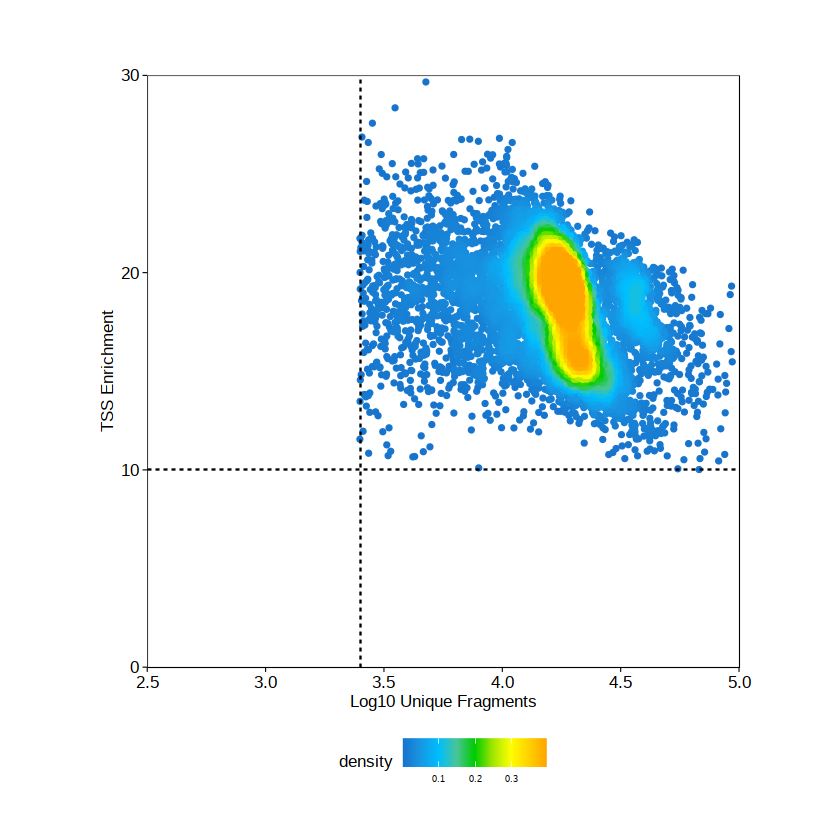

In [10]:
df <- getCellColData(scatacProj, select = c("log10(nFrags)", "TSSEnrichment"))
p <- ggPoint(
    x = df[,1], 
    y = df[,2], 
    colorDensity = TRUE,
    continuousSet = "sambaNight",
    xlabel = "Log10 Unique Fragments",
    ylabel = "TSS Enrichment",
    xlim = c(2.5, 5),
    ylim = c(0, 30)
) + geom_hline(yintercept = 10, lty = "dashed") + geom_vline(xintercept = 3.4, lty = "dashed")
p

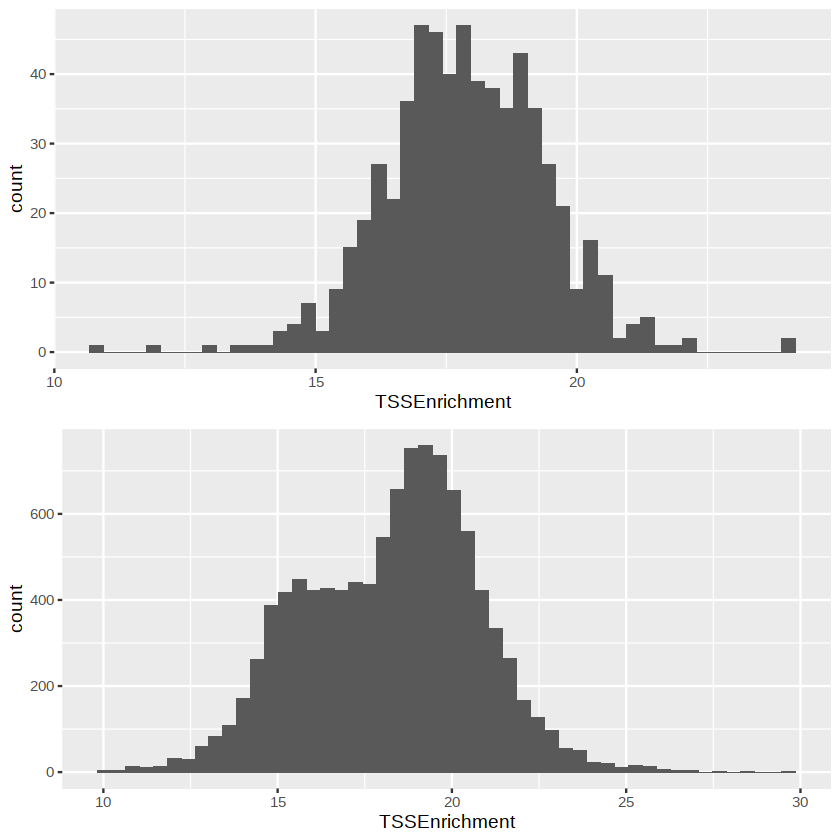

In [11]:
# attributes(scatacProj)
df = as.data.frame(getCellColData(scatacProj, select = c("DoubletEnrichment", "TSSEnrichment")))
p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=TSSEnrichment)) + geom_histogram(bins=50)
p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=TSSEnrichment)) + geom_histogram(bins=50)
grid.arrange(p1, p2, nrow = 2)

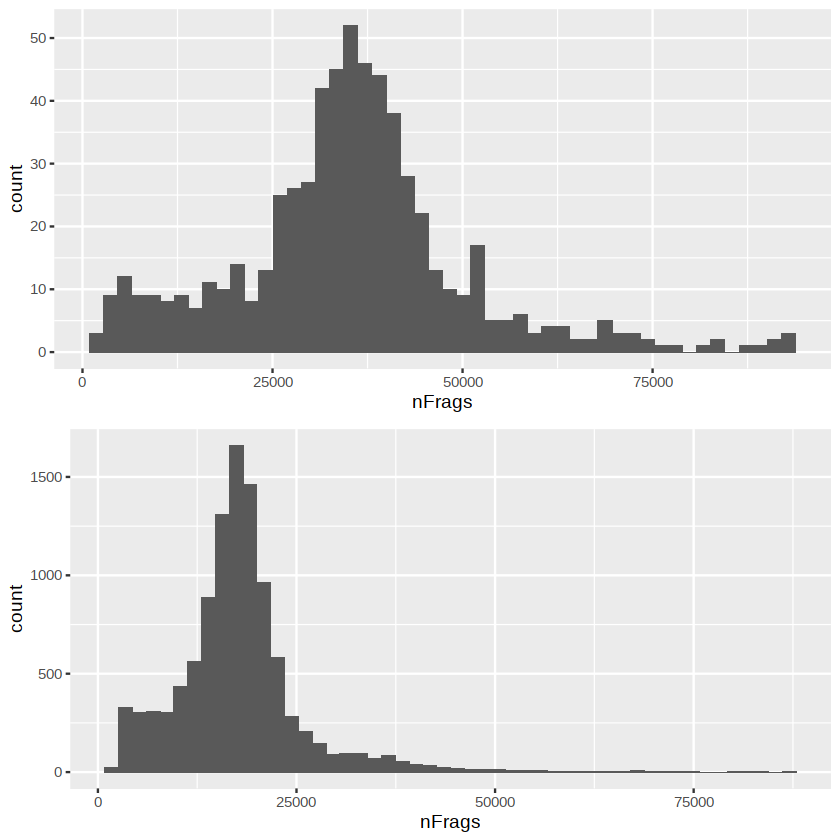

In [12]:
df = as.data.frame(getCellColData(scatacProj, select = c("DoubletEnrichment", "nFrags")))
p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=nFrags)) + geom_histogram(bins=50)
p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=nFrags)) + geom_histogram(bins=50)
grid.arrange(p1, p2, nrow = 2)

In [13]:
TileMatrix <- getMatrixFromProject(scatacProj, useMatrix='TileMatrix', binarize=TRUE)
TileMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-382f8450bd6b8-Date-2022-06-03_Time-10-29-07.log
If there is an issue, please report to github with logFile!

2022-06-03 10:32:53 : Organizing colData, 3.773 mins elapsed.

2022-06-03 10:32:53 : Organizing rowData, 3.773 mins elapsed.

2022-06-03 10:32:53 : Organizing rowRanges, 3.773 mins elapsed.

2022-06-03 10:32:53 : Organizing Assays (1 of 1), 3.773 mins elapsed.

2022-06-03 10:32:53 : Constructing SummarizedExperiment, 3.773 mins elapsed.

2022-06-03 10:32:55 : Finished Matrix Creation, 3.812 mins elapsed.



class: SummarizedExperiment 
dim: 6062095 11086 
metadata(0):
assays(1): TileMatrix
rownames: NULL
rowData names(3): seqnames idx start
colnames(11086): coassay_analysis#TAGCTAGGTTTGGGTA-1
  coassay_analysis#ACGAACAAGACACTTA-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(15): BlacklistRatio DoubletEnrichment ... Sample
  TSSEnrichment

In [14]:
df$tilesum <- colSums(assays(TileMatrix)$TileMatrix, dims=1)

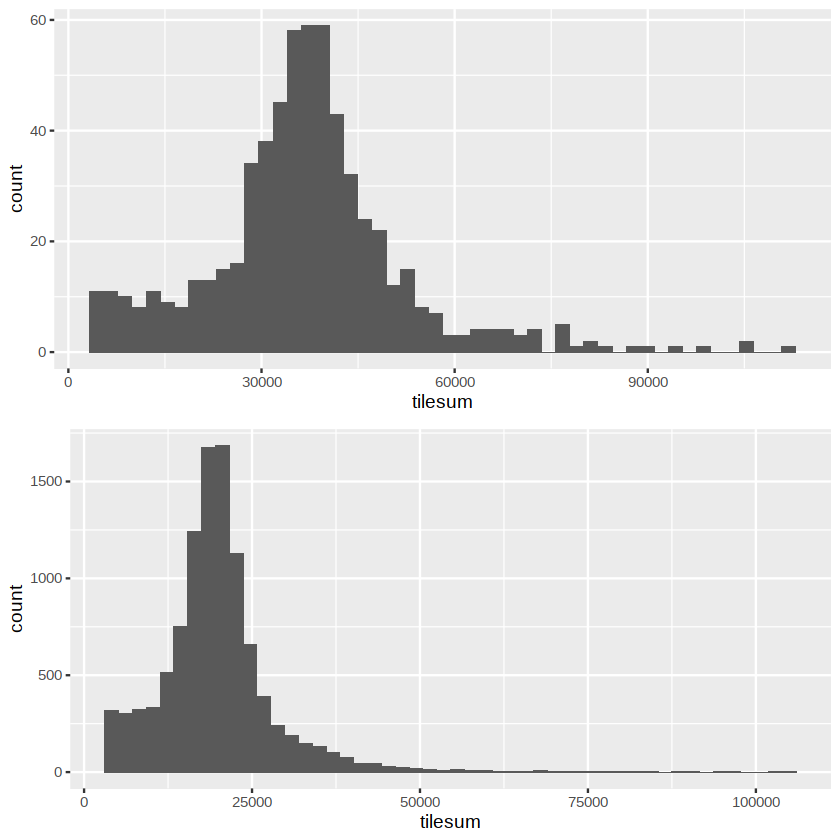

In [15]:
p1 <- ggplot(df[df['DoubletEnrichment']>=4,], aes(x=tilesum)) + geom_histogram(bins=50)
p2 <- ggplot(df[df['DoubletEnrichment']<4,], aes(x=tilesum)) + geom_histogram(bins=50)
grid.arrange(p1, p2, nrow = 2)

In [16]:
# filterRatio threshold formula from 
# https://www.archrproject.com/reference/filterDoublets.html

dim(df[df['DoubletEnrichment']>=4,])[1] / (dim(df)[1]**2/100000)

[1] 0.506105

In [17]:
# filter doublets

scatacProj <- filterDoublets(ArchRProj = scatacProj, filterRatio = 0.51)

Filtering 626 cells from ArchRProject!

	coassay_analysis : 626 of 11086 (5.6%)



# clustering

In [18]:
# LSI based on TileMatrix (reduce dimensionality)

scatacProj <- addIterativeLSI(ArchRProj = scatacProj, useMatrix = "TileMatrix", name = "IterativeLSI")

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-382f81867aac3-Date-2022-06-03_Time-10-34-16.log
If there is an issue, please report to github with logFile!

2022-06-03 10:34:17 : Computing Total Across All Features, 0.001 mins elapsed.

2022-06-03 10:34:18 : Computing Top Features, 0.026 mins elapsed.

###########
2022-06-03 10:34:20 : Running LSI (1 of 2) on Top Features, 0.06 mins elapsed.
###########

2022-06-03 10:34:21 : Sampling Cells (N = 10000) for Estimated LSI, 0.062 mins elapsed.

2022-06-03 10:34:21 : Creating Sampled Partial Matrix, 0.062 mins elapsed.

2022-06-03 10:35:07 : Computing Estimated LSI (projectAll = FALSE), 0.828 mins elapsed.

2022-06-03 10:37:40 : Identifying Clusters, 3.384 mins elapsed.

2022-06-03 10:37:54 : Identified 6 Clusters, 3.623 mins elapsed.

2022-06-03 10:37:54 : Saving LSI Iteration, 3.623 mins elapsed.

2022-06-03 10:38:16 : Creating Cluster Matrix on the total Group Features, 3.992 mins elapsed.

2022-06-03 10:38:38 : C

In [19]:
# call clusters based on Seurat’s graph clustering

scatacProj <- addClusters(input = scatacProj, reducedDims = "IterativeLSI")

ArchR logging to : ArchRLogs/ArchR-addClusters-382f8f7daf22-Date-2022-06-03_Time-10-44-54.log
If there is an issue, please report to github with logFile!

2022-06-03 10:44:55 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.003 mins elapsed.

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10460
Number of edges: 403219

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8908
Number of communities: 19
Elapsed time: 1 seconds


2022-06-03 10:45:08 : Testing Biased Clusters, 0.219 mins elapsed.

2022-06-03 10:45:08 : Identified Biased Clusters (n = 2), set filterBias = TRUE to re-assign these cells: , 0.22 mins elapsed.

Biased Clusters : 
Cluster1 
Cluster8 


2022-06-03 10:45:08 : Testing Outlier Clusters, 0.221 mins elapsed.

2022-06-03 10:45:08 : Assigning Cluster Names to 19 Clusters, 0.221 mins elapsed.

2022-06-03 10:45:08 : Finished addClusters, 0.222 mins elapsed.



In [20]:
# UMAP and cluster

scatacProj <- addUMAP(ArchRProj = scatacProj, reducedDims = "IterativeLSI")

10:46:47 UMAP embedding parameters a = 0.7669 b = 1.223

10:46:47 Read 10460 rows and found 30 numeric columns

10:46:47 Using Annoy for neighbor search, n_neighbors = 40

10:46:47 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:46:49 Writing NN index file to temp file /tmp/Rtmpi4kKcm/file382f85eb54aa1

10:46:49 Searching Annoy index using 48 threads, search_k = 4000

10:46:49 Annoy recall = 100%

10:46:51 Commencing smooth kNN distance calibration using 48 threads

10:46:52 Initializing from normalized Laplacian + noise

10:46:53 Commencing optimization for 200 epochs, with 594532 positive edges

10:47:08 Optimization finished

10:47:08 Creating temp model dir /tmp/Rtmpi4kKcm/dir382f81b3282fe

10:47:08 Creating dir /tmp/Rtmpi4kKcm/dir382f81b3282fe

10:47:09 Changin

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-382f870823d63-Date-2022-06-03_Time-11-05-17.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-382f870823d63-Date-2022-06-03_Time-11-05-17.log



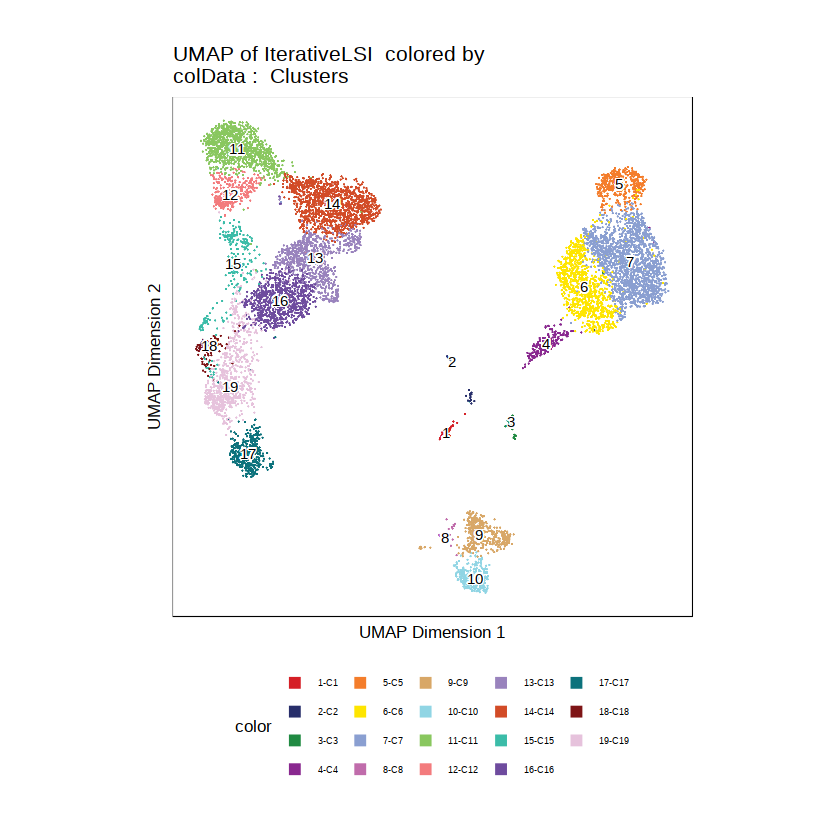

In [21]:
# plot clusters

pp <- plotEmbedding(ArchRProj = scatacProj, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
pp

In [22]:
# save figures
plotPDF(pp, name = "Plot-UMAP-Cell-Clusters.pdf",
        ArchRProj = scatacProj, addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!



# Assigning Clusters with Gene Scores

In [23]:
# add imputation weights using MAGIC to help smooth the dropout noise in our gene scores.

scatacProj <- addImputeWeights(scatacProj)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-382f857b9f15-Date-2022-06-03_Time-11-05-37.log
If there is an issue, please report to github with logFile!

2022-06-03 11:05:37 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.

Warning message in sprintf("Completed Getting Magic Weights!", round(object.size(weightList)/10^9, :
“one argument not used by format 'Completed Getting Magic Weights!'”


In [24]:
# define marker genes and make plots

markerGenes  <- c(
    "CD4",  # helper T cell
    "CD8A",  # cytotoxic T cell 
    "CD79A",# B cell
    "TCF7", # memory and naïve T cells
    "IFNG", # CD8 effectors (cytotoxic T cells)
    "IKZF2", # regulatory T cells
    "CD28" # T cell activation
  )

p <- plotEmbedding(
    ArchRProj = scatacProj, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(scatacProj)
)

Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-382f83738bf97-Date-2022-06-03_Time-11-16-15.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2022-06-03 11:16:16 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-382f83738bf97-Date-2022-06-03_Time-11-16-15.log



Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”


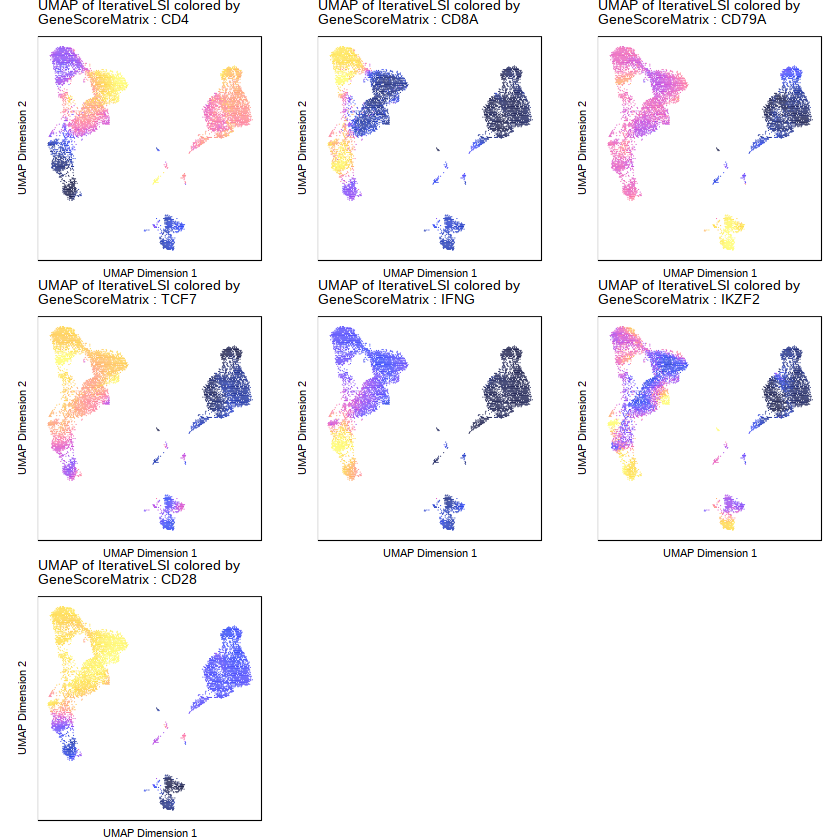

In [25]:
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))

In [26]:
# Method1: 
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 8, 9, 10
# CD8A: 11, 12, 19
# CD28: 13, 14, 15, 16
# IKZF2: 2, 17, 18
# Method2:
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 2, 8, 9, 10, 11, 12, 17, 18, 19
# CD28: 13, 14, 15, 16

In [27]:
plotPDF(plotList = p2, 
    name = "Plot-UMAP-Marker-Genes-W-Imputation.pdf", 
    ArchRProj = scatacProj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!

Plotting Ggplot!



# Visualizing Genome Browser Tracks

In [28]:
# browse the local chromatin accessibility at these marker genes on a per cluster basis with genome browser tracks

p <- plotBrowserTrack(
    ArchRProj = scatacProj, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-382f824ad0086-Date-2022-06-03_Time-11-24-56.log
If there is an issue, please report to github with logFile!

2022-06-03 11:24:56 : Validating Region, 0.012 mins elapsed.



GRanges object with 7 ranges and 2 metadata columns:
      seqnames              ranges strand |     gene_id      symbol
         <Rle>           <IRanges>  <Rle> | <character> <character>
  [1]    chr12     6786858-6820808      + |         920         CD4
  [2]     chr2   86784610-86808396      - |         925        CD8A
  [3]    chr19   41877120-41881372      + |         973       CD79A
  [4]     chr5 134114711-134151865      + |        6932        TCF7
  [5]    chr12   68154768-68159747      - |        3458        IFNG
  [6]     chr2 212999691-213152427      - |       22807       IKZF2
  [7]     chr2 203706475-203738912      + |         940        CD28
  -------
  seqinfo: 24 sequences from hg38 genome


2022-06-03 11:24:57 : Adding Bulk Tracks (1 of 7), 0.015 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-03 11:25:00 : Adding Gene Tracks (1 of 7), 0.069 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-03 11:25:00 : Plotting, 0.076 mins elapsed.

2022-06-03 11:25:05 : Adding Bulk Tracks (2 of 7), 0.149 mins elapsed.

Getting Region From Arrow Files 1 of 1

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-03 11:25:09 : Adding Gene Tracks (2 of 7), 0.227 mins elapsed.

Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
2022-06-03 11:25:10 : Plotting, 0.233 mins elapsed.

2022-06-03 11:25:13 : Adding Bulk Tracks (3 of 7), 0.284 mins elapsed.

Getting Region From Arrow 

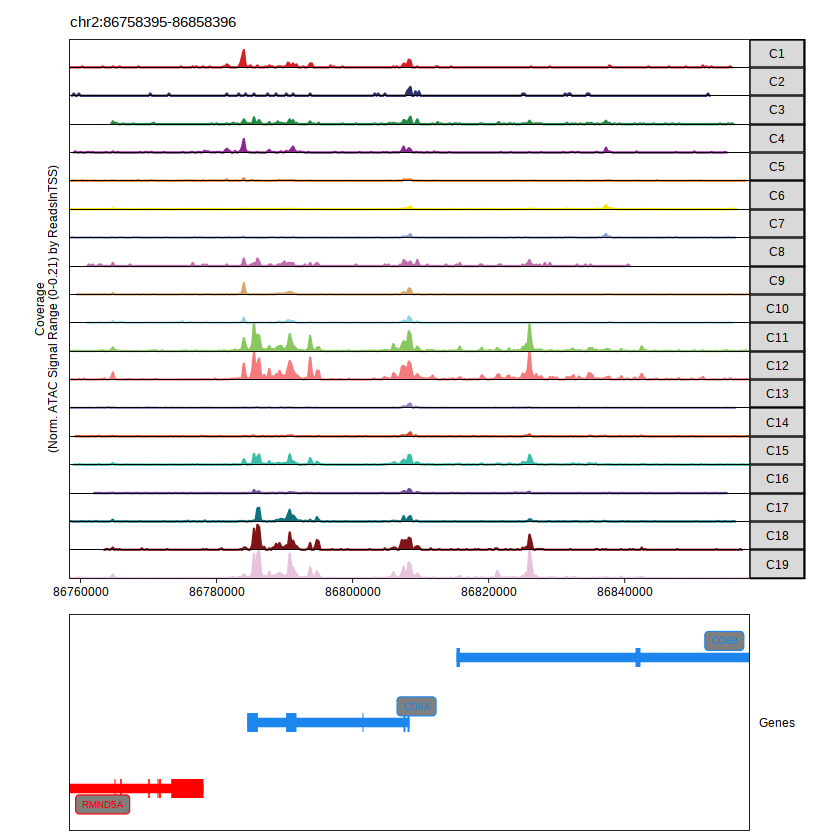

In [29]:
# plot CD14 gene accessibility at different clusters

grid::grid.newpage()
grid::grid.draw(p$CD8A)

In [30]:
plotPDF(plotList = p, 
    name = "Plot-Tracks-Marker-Genes.pdf", 
    ArchRProj = scatacProj, 
    addDOC = FALSE, width = 5, height = 5)

Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


Plotting Gtable!



NULL


In [39]:
# CD4: 1, 3, 4, 5, 6, 7
# CD79A: 2, 8, 9, 10, 11, 12, 17, 18, 19
# CD28: 13, 14, 15, 16

remapClust <- c(
    "C1" = "CD4",
    "C2" = "CD79A",
    "C3" = "CD4",
    "C4" = "CD4",
    "C5" = "CD4",
    "C6" = "CD4",
    "C7" = "CD4",
    "C8" = "CD79A",
    "C9" = "CD79A",
    "C10" = "CD79A",
    "C11" = "CD79A",
    "C12" = "CD79A",
    "C13" = "CD28",
    "C14" = "CD28",
    "C15" = "CD28",
    "C16" = "CD28",
    "C17" = "CD79A",
    "C18" = "CD79A",
    "C19" = 'CD79A')

In [40]:
scatacProj$ClustersAnnotated2 <- mapLabels(scatacProj$Clusters, oldLabels = names(remapClust), newLabels = remapClust)

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-382f84f365077-Date-2022-06-03_Time-11-37-05.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-382f84f365077-Date-2022-06-03_Time-11-37-05.log



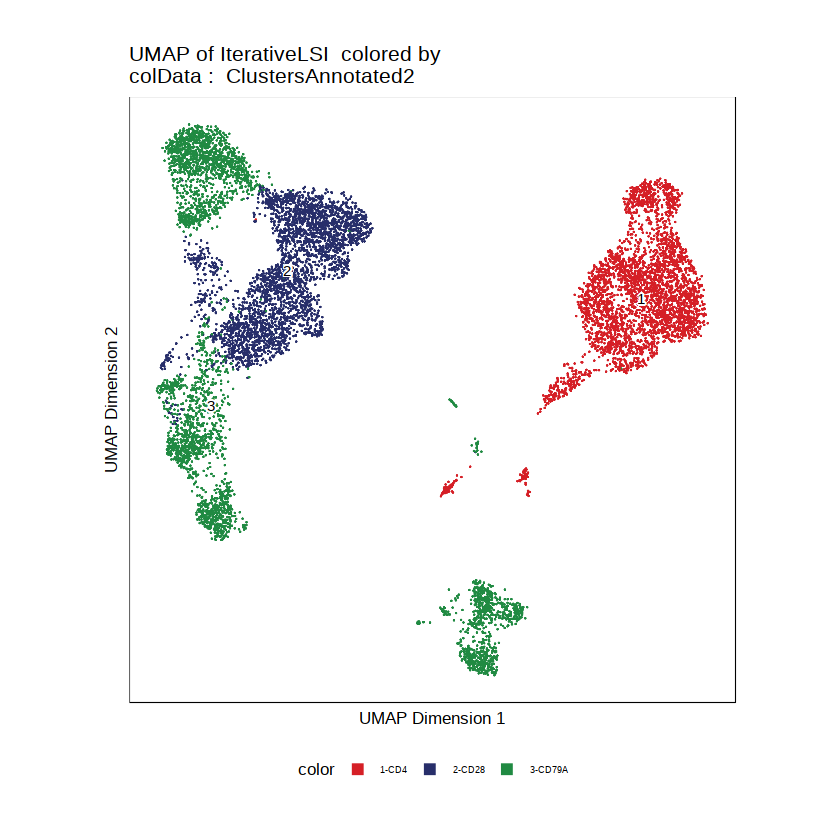

In [41]:
pp <- plotEmbedding(ArchRProj = scatacProj, colorBy = "cellColData", name = "ClustersAnnotated2", embedding = "UMAP")
pp

In [42]:
saveArchRProject(ArchRProj = scatacProj, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



# peak calling

In [43]:
scatacProj$ClustersAnnotated2

[1] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [10] "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [19] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28" 
   [28] "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [37] "CD79A" "CD4"   "CD28"  "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [46] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD4"   "CD4"   "CD4"  
   [55] "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD79A" "CD79A" "CD28" 
   [64] "CD4"   "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD79A" "CD4"  
   [73] "CD4"   "CD79A" "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD79A" "CD4"  
   [82] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
   [91] "CD4"   "CD28"  "CD4"   "CD79A" "CD28"  "CD4"   "CD4"   "CD4"   "CD4"  
  [100] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD28" 
  [109] "CD4"   "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD4"  
  [118] "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD79A" "CD28"  "CD4"  
  [127] "CD79A" "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28" 
  [136] "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
  [145] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD79A" "CD4"  
  [154] "CD79A" "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [163] "CD4"   "CD4"   "CD28"  "CD4"   "CD4"   "CD79A" "CD4"   "CD4"   "CD4"  
  [172] "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD28" 
  [181] "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD4"  
  [190] "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"  
  [199] "CD28"  "CD4"   "CD79A" "CD4"   "CD4"   "CD28"  "CD79A" "CD4"   "CD28" 
  [208] "CD28"  "CD4"   "CD28"  "CD4"   "CD79A" "CD4"   "CD28"  "CD4"   "CD4"  
  [217] "CD28"  "CD28"  "CD28"  "CD4"   "CD79A" "CD28"  "CD28"  "CD4"   "CD28" 
  [226] "CD28"  "CD28"  "CD28"  "CD28"  "CD28"  "CD79A" "CD4"   "CD4"   "CD4"  
  [235] "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD79A" "CD28"  "CD28"  "CD28" 
  [244] "CD28"  "CD79A" "CD79A" "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD28" 
  [253] "CD28"  "CD4"   "CD28"  "CD28"  "CD28"  "CD28"  "CD28"  "CD79A" "CD4"  
  [262] "CD28"  "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD79A" "CD28"  "CD4"  
  [271] "CD4"   "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD28"  "CD4"   "CD28" 
  [280] "CD28"  "CD4"   "CD4"   "CD28"  "CD79A" "CD4"   "CD4"   "CD28"  "CD28" 
  [289] "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD28"  "CD4"   "CD79A" "CD28" 
  [298] "CD4"   "CD4"   "CD28"  "CD28"  "CD28"  "CD79A" "CD28"  "CD79A" "CD28" 
  [307] "CD28"  "CD4"   "CD28"  "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD28" 
  [316] "CD4"   "CD28"  "CD4"   "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD28" 
  [325] "CD28"  "CD79A" "CD28"  "CD4"   "CD4"   "CD79A" "CD28"  "CD4"   "CD28" 
  [334] "CD4"   "CD28"  "CD79A" "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD79A"
  [343] "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD28" 
  [352] "CD28"  "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD4"   "CD4"   "CD28" 
  [361] "CD79A" "CD4"   "CD28"  "CD4"   "CD28"  "CD28"  "CD4"   "CD79A" "CD28" 
  [370] "CD4"   "CD4"   "CD79A" "CD4"   "CD4"   "CD4"   "CD28"  "CD79A" "CD79A"
  [379] "CD28"  "CD4"   "CD28"  "CD28"  "CD28"  "CD4"   "CD28"  "CD28"  "CD79A"
  [388] "CD4"   "CD28"  "CD79A" "CD4"   "CD28"  "CD28"  "CD79A" "CD28"  "CD4"  
  [397] "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [406] "CD79A" "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD28"  "CD4"   "CD28" 
  [415] "CD4"   "CD28"  "CD28"  "CD4"   "CD4"   "CD28"  "CD4"   "CD28"  "CD4"  
  [424] "CD4"   "CD28"  "CD4"   "CD4"   "CD4"   "CD4"   "CD4"   "CD28"  "CD4"  
  [433] "CD4"   "CD28"  "CD79A" "CD4"   "CD79A" "CD4"   "CD28"  "CD28"  "CD28" 
  [442] "CD28"  "CD28"  "CD4"   "CD79A" "CD28"  "CD4"   "CD28"  "CD28"  "CD28" 
  [4

In [44]:
pathToMacs2 <- '/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2'
pathToMacs2

[1] "/Genomics/grid/users/zz5084/anaconda3/envs/r/bin/macs2"

In [45]:
scatacProj <- addGroupCoverages(scatacProj, groupBy = "ClustersAnnotated2", force = TRUE) 

ArchR logging to : ArchRLogs/ArchR-addGroupCoverages-382f851dcb3a9-Date-2022-06-03_Time-11-37-26.log
If there is an issue, please report to github with logFile!

CD4 (1 of 3) : CellGroups N = 2

CD28 (2 of 3) : CellGroups N = 2

CD79A (3 of 3) : CellGroups N = 2

2022-06-03 11:37:27 : Creating Coverage Files!, 0.018 mins elapsed.

2022-06-03 11:37:27 : Batch Execution w/ safelapply!, 0.018 mins elapsed.

2022-06-03 11:38:32 : Adding Kmer Bias to Coverage Files!, 1.105 mins elapsed.

Completed Kmer Bias Calculation

Adding Kmer Bias (1 of 6)

Adding Kmer Bias (2 of 6)

Adding Kmer Bias (3 of 6)

Adding Kmer Bias (4 of 6)

Adding Kmer Bias (5 of 6)

Adding Kmer Bias (6 of 6)

2022-06-03 11:39:08 : Finished Creation of Coverage Files!, 1.702 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-addGroupCoverages-382f851dcb3a9-Date-2022-06-03_Time-11-37-26.log



In [27]:
?addReproduciblePeakSet()

In [46]:
scatacProj <- addReproduciblePeakSet(
    ArchRProj = scatacProj, 
    groupBy = "ClustersAnnotated2", 
    pathToMacs2 = pathToMacs2,
    force = TRUE
)

ArchR logging to : ArchRLogs/ArchR-addReproduciblePeakSet-382f83e9339ee-Date-2022-06-03_Time-11-39-25.log
If there is an issue, please report to github with logFile!

Calling Peaks with Macs2

2022-06-03 11:39:26 : Peak Calling Parameters!, 0.021 mins elapsed.



      Group nCells nCellsUsed nReplicates nMin nMax maxPeaks
CD4     CD4   3571        540           2   40  500   150000
CD28   CD28   3281        540           2   40  500   150000
CD79A CD79A   3608        540           2   40  500   150000


2022-06-03 11:39:26 : Batching Peak Calls!, 0.021 mins elapsed.

2022-06-03 11:39:26 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-03 11:41:23 : Identifying Reproducible Peaks!, 1.977 mins elapsed.

2022-06-03 11:41:33 : Creating Union Peak Set!, 2.137 mins elapsed.

Converged after 4 iterations!

Plotting Ggplot!

2022-06-03 11:41:39 : Finished Creating Union Peak Set (89280)!, 2.243 mins elapsed.



In [47]:
head(getPeakSet(scatacProj))

GRanges object with 6 ranges and 13 metadata columns:
        seqnames        ranges strand |     score replicateScoreQuantile
           <Rle>     <IRanges>  <Rle> | <numeric>              <numeric>
    CD4     chr1 817096-817596      * | 147.29500                  0.886
    CD4     chr1 820721-821221      * |   3.16766                  0.228
    CD4     chr1 826608-827108      * |   3.16766                  0.228
    CD4     chr1 827290-827790      * | 298.87500                  0.939
  CD79A     chr1 857895-858395      * |  15.97850                  0.505
  CD79A     chr1 865600-866100      * |  17.29950                  0.523
        groupScoreQuantile Reproducibility GroupReplicate distToGeneStart
                 <numeric>       <numeric>    <character>       <integer>
    CD4              0.730               2     CD4._.Rep1              24
    CD4              0.034               2     CD4._.Rep2            3599
    CD4              0.034               2     CD4._.Rep2         

In [48]:
saveArchRProject(ArchRProj = scatacProj, outputDirectory = archr_out, load = FALSE)

Saving ArchRProject...



In [49]:
scatac_peak <- addPeakMatrix(scatacProj, ceiling = 20)

ArchR logging to : ArchRLogs/ArchR-addPeakMatrix-382f8517a4b93-Date-2022-06-03_Time-11-43-40.log
If there is an issue, please report to github with logFile!

2022-06-03 11:43:40 : Batch Execution w/ safelapply!, 0 mins elapsed.

2022-06-03 11:43:41 : Adding coassay_analysis to PeakMatrix for Chr (1 of 23)!, 0.01 mins elapsed.

2022-06-03 11:44:02 : Adding coassay_analysis to PeakMatrix for Chr (2 of 23)!, 0.357 mins elapsed.

2022-06-03 11:44:16 : Adding coassay_analysis to PeakMatrix for Chr (3 of 23)!, 0.593 mins elapsed.

2022-06-03 11:44:27 : Adding coassay_analysis to PeakMatrix for Chr (4 of 23)!, 0.781 mins elapsed.

2022-06-03 11:44:36 : Adding coassay_analysis to PeakMatrix for Chr (5 of 23)!, 0.918 mins elapsed.

2022-06-03 11:44:45 : Adding coassay_analysis to PeakMatrix for Chr (6 of 23)!, 1.079 mins elapsed.

2022-06-03 11:44:57 : Adding coassay_analysis to PeakMatrix for Chr (7 of 23)!, 1.267 mins elapsed.

2022-06-03 11:45:06 : Adding coassay_analysis to PeakMatrix for C

In [50]:
getAvailableMatrices(scatac_peak)

[1] "GeneScoreMatrix" "PeakMatrix"      "TileMatrix"

In [51]:
PeakMatrix <- getMatrixFromProject(scatacProj, useMatrix='PeakMatrix', binarize=FALSE)
PeakMatrix

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-382f81670eca1-Date-2022-06-03_Time-11-53-40.log
If there is an issue, please report to github with logFile!

2022-06-03 11:54:44 : Organizing colData, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing rowData, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing rowRanges, 1.063 mins elapsed.

2022-06-03 11:54:44 : Organizing Assays (1 of 1), 1.063 mins elapsed.

2022-06-03 11:54:44 : Constructing SummarizedExperiment, 1.064 mins elapsed.

2022-06-03 11:54:46 : Finished Matrix Creation, 1.107 mins elapsed.



class: RangedSummarizedExperiment 
dim: 89280 10460 
metadata(0):
assays(1): PeakMatrix
rownames: NULL
rowData names(1): idx
colnames(10460): coassay_analysis#AAACCGCGTACTTCAC-1
  coassay_analysis#GGTTGCGGTAAACAAG-1 ...
  coassay_analysis#TCTAACCGTAGTCAAT-1
  coassay_analysis#ATTCGTTTCAGGTTTA-1
colData names(18): BlacklistRatio DoubletEnrichment ...
  ClustersAnnotated ClustersAnnotated2

In [53]:
writeMM(assays(PeakMatrix)$PeakMatrix, paste(archr_out, "PBMC_peak_cell_matrix.mtx", sep="/"))

NULL

In [56]:
write.table(getPeakSet(scatacProj), paste(archr_out, "PBMC_peaks.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE, row.names = FALSE)
write.table(colData(PeakMatrix), paste(archr_out, "PBMC_cellnames_info.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)

lsi_object = getReducedDims(
  ArchRProj = scatacProj,
  reducedDims = "IterativeLSI",
  returnMatrix = TRUE,
  dimsToUse = NULL,
  scaleDims = NULL,
  corCutOff = 0.75
)

write.table(lsi_object, paste(archr_out, "PBMC_Iterative_LSI.txt", sep="/"), append = FALSE, sep = "\t", quote = FALSE)